In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')  # Adds the parent directory to the path for custom module imports

# Ignorar warings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
from src.support_eda import plot_categoric_distribution, plot_correlation_matrix, plot_numeric_distribution, plot_relation_tv_numeric, plot_outliers

from src.support_null_handling import MissingValuesHandler

In [2]:
df = pd.read_csv('../data/output/autorenew_eda.csv', index_col=0).reset_index(drop=True)

## Contexto

Somos una empresa que se encarga de buscar vehículos de segunda mano para vender a nuestros clientes. Nuestros principales clientes son personas o familias que buscan un vehículo asequible que pueda cumplir con sus necesidades.

Para seleccionar los vehículos que estaríamos en disposición de vender utilizaremos diferentes criterios para filtrar nuestros datos nuevamente y así poder construir un modelo predictivo eficaz.

### Criterios y filtros

`price`: El precio máximo que nuestros clientes están dispuestos a pagar es 30000, por lo que dejaremos un margen de seguridad del 100% estableciendo el límite en 60000, para así no descartar a potenciales vehículos en un rango que nos pueda interesar pero sí dejar fuera a vehículos de lujo o excesivamente caros como para que puedan ser objeto de compra de nuestros clientes.

`yearOfRegistration`: Para cumplir con las directrices medioambientales vigentes solamente comercializamos vehículos registrados en el siglo XXI, es decir, cuyo año de matriculación será 2001 o más reciente.

`powerCV`: En general vehículos con una potencia superior a 300CV se consideran de alta gama, por lo que dejaremos el límite superior en 400 CV.

`notRepairedDamage`: Queremos estar completamente seguros de que los vehículos no tienen daños sin reparar, por lo que solamente vamos a tomar vehíulos que cumplan esta condición.

Aplicamos los filtros

In [3]:
filter_price = df['price'] <= 60000
filter_year = df['yearOfRegistration'] > 2000
filter_power = df['powerCV'] <= 400
filter_damage = df['notRepairedDamage'] == 'no'

In [4]:
df.groupby('notRepairedDamage')['price'].median().round(2)

notRepairedDamage
no         4000.0
unkonwn    1650.0
yes        1000.0
Name: price, dtype: float64

Antes de aplicar los filtros vemos que el precio mediano de los vehículos sin daños es 4 veces mayor que los que tienen daños, mientras que los que tienen esta categoría como desconocida se acercan mucho más a los dañados que a los no dañados. Esto no tiene por qué significar que tengan daños, pero refuerza el hecho de que tomemos solo los vehículos que tengamos confirmación de que están en buen estado.

In [5]:
filtered_df = df[filter_price & filter_year & filter_power & filter_damage]

print(f"We kept {filtered_df.shape[0]} entries which represent {round(filtered_df.shape[0] / df.shape[0] * 100, 2)}% of the total data")

We kept 172432 entries which represent 48.85% of the total data


Now the column `notRepairedDamage` makes no sense since all values are `'no'`. Let's drop it.

In [6]:
filtered_df.drop(columns='notRepairedDamage', inplace=True)

Let's take a quick view before saving this dataframe

In [7]:
filtered_df

,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand
3,1500,small car,2001.0,manually,74.0,150000,petrol,volkswagen
4,3600,small car,2008.0,manually,68.0,90000,diesel,skoda
6,2200,convertible,2004.0,manually,108.0,150000,petrol,peugeot
9,2000,unkonwn,2004.0,manually,104.0,150000,petrol,mazda
12,2500,combi,2004.0,manually,129.0,150000,unkonwn,volkswagen
...,...,...,...,...,...,...,...,...
352962,6500,unkonwn,2003.0,automatic,143.0,150000,diesel,mercedes_benz
352965,4400,unkonwn,2008.0,manually,104.0,150000,diesel,seat
352969,7900,unkonwn,2010.0,manually,138.0,150000,diesel,volkswagen
352971,5250,unkonwn,2016.0,automatic,148.0,150000,unkonwn,alfa_romeo


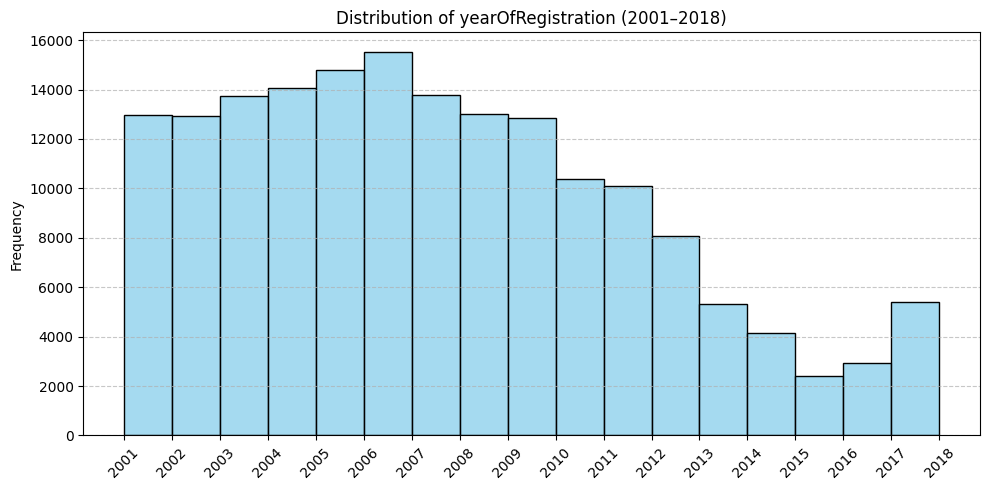

In [8]:
plot_numeric_distribution(filtered_df, 2001, 2018, 'yearOfRegistration', n=1)

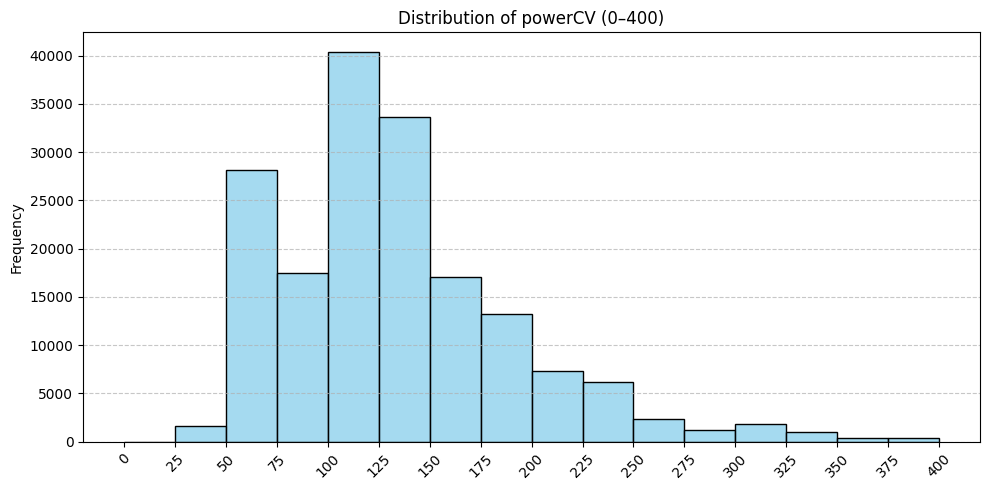

In [9]:
plot_numeric_distribution(filtered_df, 0, 400, 'powerCV', n = 25)

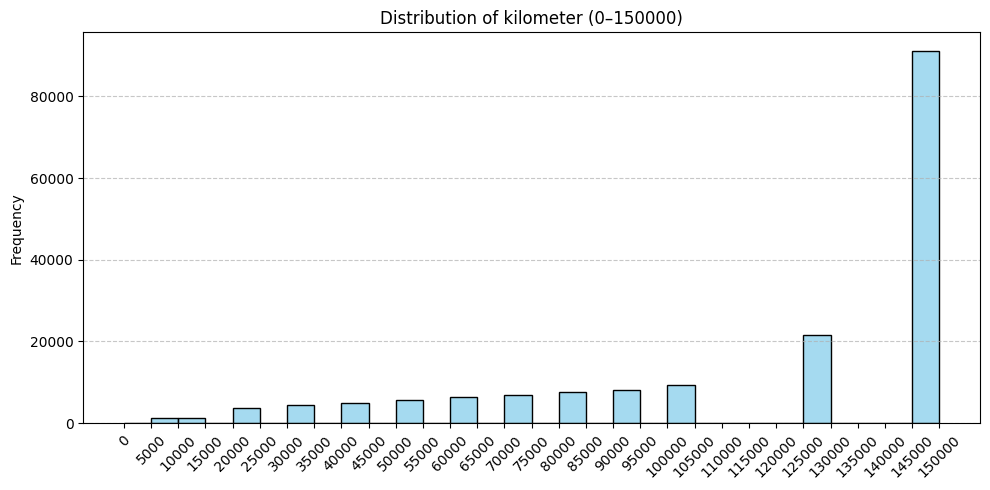

In [10]:
plot_numeric_distribution(filtered_df, 0, 150000, 'kilometer', n = 5000)

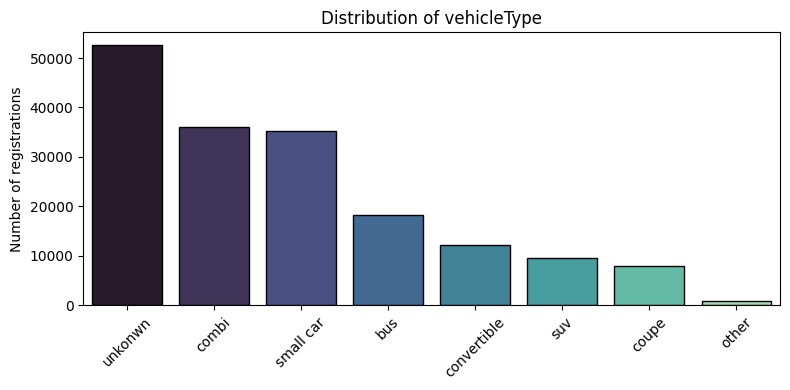

In [11]:
plot_categoric_distribution(filtered_df, 'vehicleType')

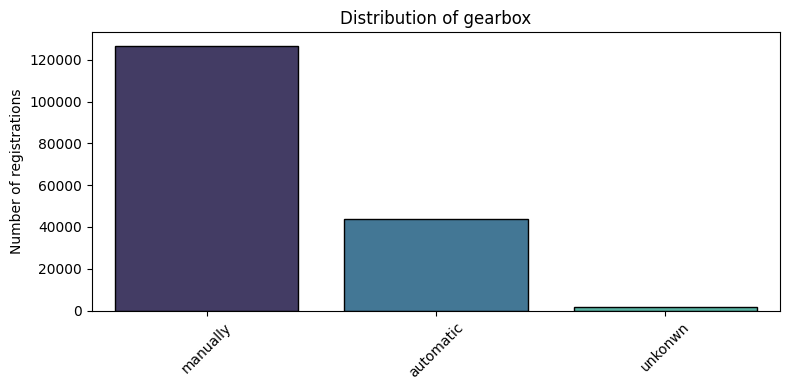

In [12]:
plot_categoric_distribution(filtered_df, 'gearbox')

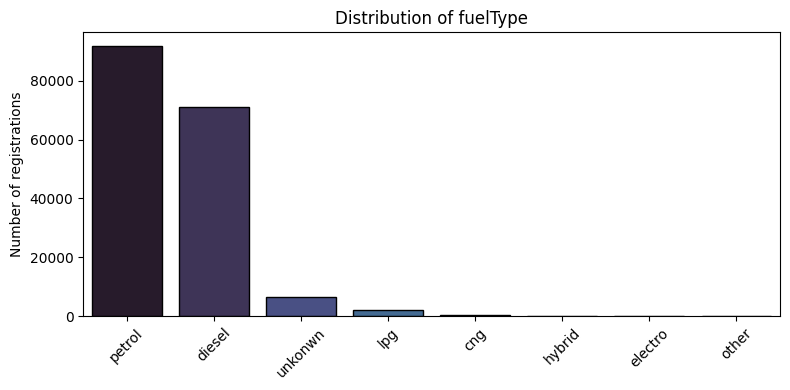

In [13]:
plot_categoric_distribution(filtered_df, 'fuelType')

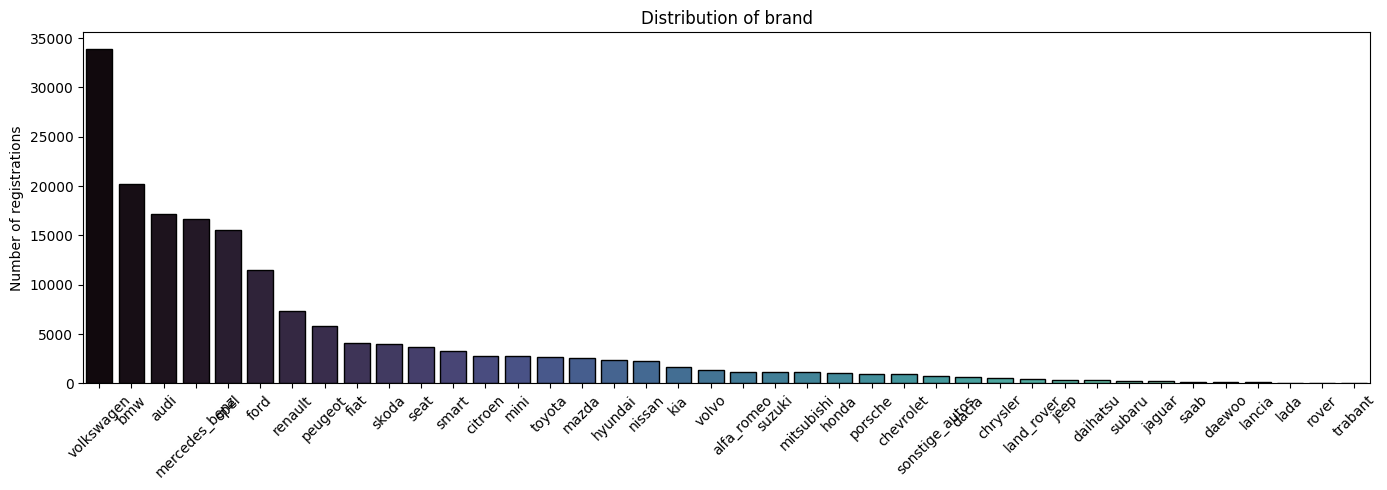

In [14]:
plot_categoric_distribution(filtered_df, 'brand', size=(14, 5))

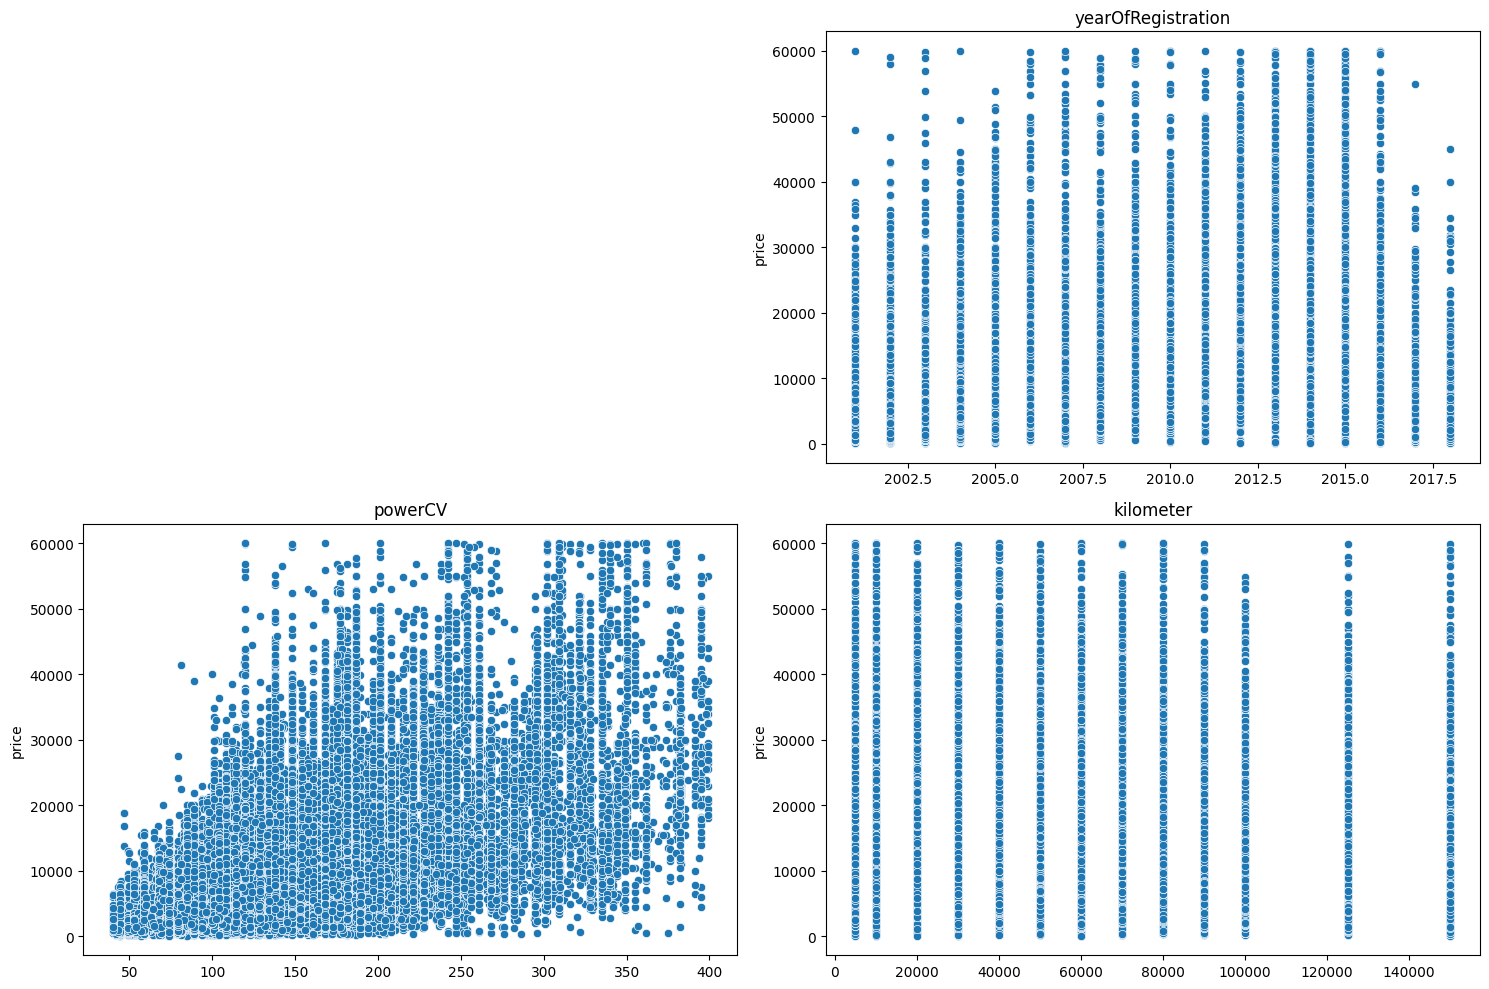

In [15]:
plot_relation_tv_numeric(filtered_df, 'price')

Los diagramas de dispersión no nos ayudan mucho. Veamos la correlación con el mapa de calor

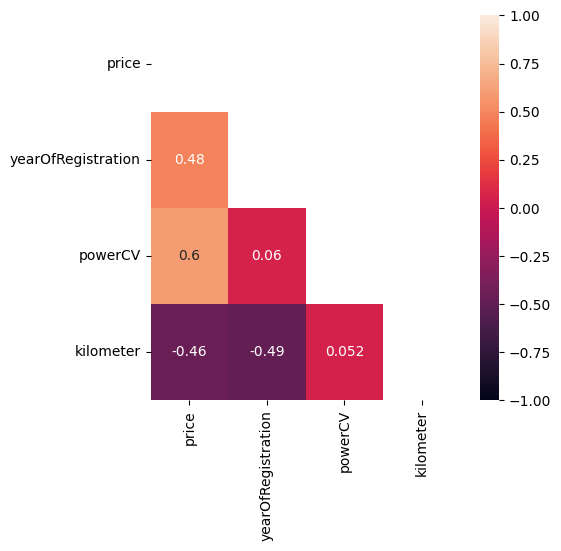

In [16]:
plot_correlation_matrix(filtered_df)

Ahora las correlaciones son más fuertes y significativas, por lo que en el segmento de vehículos de nuestro interés sí parece haber una relación más clara entre las variables ya comentadas en el EDA.

Guardamos el dataframe en CSV

In [17]:
filtered_df.to_csv('../data/output/autorenew_segmented.csv')

In [18]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172432 entries, 3 to 352978
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               172432 non-null  int64  
 1   vehicleType         172432 non-null  object 
 2   yearOfRegistration  172432 non-null  float64
 3   gearbox             172432 non-null  object 
 4   powerCV             172432 non-null  float64
 5   kilometer           172432 non-null  int64  
 6   fuelType            172432 non-null  object 
 7   brand               172432 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 11.8+ MB


---

Nulos

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352979 entries, 0 to 352978
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               352979 non-null  int64  
 1   vehicleType         352979 non-null  object 
 2   yearOfRegistration  352807 non-null  float64
 3   gearbox             352979 non-null  object 
 4   powerCV             316255 non-null  float64
 5   kilometer           352979 non-null  int64  
 6   fuelType            352979 non-null  object 
 7   brand               352979 non-null  object 
 8   notRepairedDamage   352979 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 24.2+ MB


Los nulos en las variables categóricas ya los habíamos imputado como una categoría desconocida. Sin embargo, todavía existen algunos valores nulo para las variables numéricas. Veamos cómo gestionarlas

In [20]:
missing_values = MissingValuesHandler(df)

In [21]:
missing_values.get_missing_values_percentages()

yearOfRegistration     0.048728
powerCV               10.404018
dtype: float64

In [22]:
missing_values.select_missing_values_columns().to_list()

['yearOfRegistration', 'powerCV']

In [23]:
missing_values.use_knn()

,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage,yearOfRegistration_knn,powerCV_knn
0,480,unkonwn,1993.0,manually,NaN,150000,petrol,volkswagen,unkonwn,1993.0,130.6
1,18300,coupe,2011.0,manually,187.0,125000,diesel,audi,yes,2011.0,187.0
2,9800,suv,2004.0,automatic,161.0,125000,diesel,jeep,unkonwn,2004.0,161.0
3,1500,small car,2001.0,manually,74.0,150000,petrol,volkswagen,no,2001.0,74.0
4,3600,small car,2008.0,manually,68.0,90000,diesel,skoda,no,2008.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...
352974,2200,unkonwn,2005.0,unkonwn,NaN,20000,unkonwn,sonstige_autos,unkonwn,2005.0,113.6
352975,1199,convertible,2000.0,automatic,100.0,125000,petrol,smart,no,2000.0,100.0
352976,9200,bus,1996.0,manually,101.0,150000,diesel,volkswagen,no,1996.0,101.0
352977,3400,combi,2002.0,manually,99.0,150000,diesel,volkswagen,unkonwn,2002.0,99.0
